In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np






data_types = {
    'budget': float,
    'id_pelicula': str,
    'original_language': str,
    'overview': str,
    'popularity': str,
    
    'revenue': float,
    'runtime': float,
    'status': str,
    'tagline': str,
    'title': str,
    'vote_average': float,
    'vote_count': 'Int32',  # Utiliza 'Int32' para un entero nullable
    'genres_ok': str,
    'spoken_languages_ok': str,
    'production_countries': str,
    'belong_to_collection': str,
    'production_companies_ok': str,
    'return': float,
    'release_year': 'Int64'  # Utiliza 'Int64' para un entero nullable
}



df = pd.read_csv('movies_etl.csv', dtype=data_types, low_memory=False)


C:\Users\maral\AppData\Local\Temp\ipykernel_9164\3014159484.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


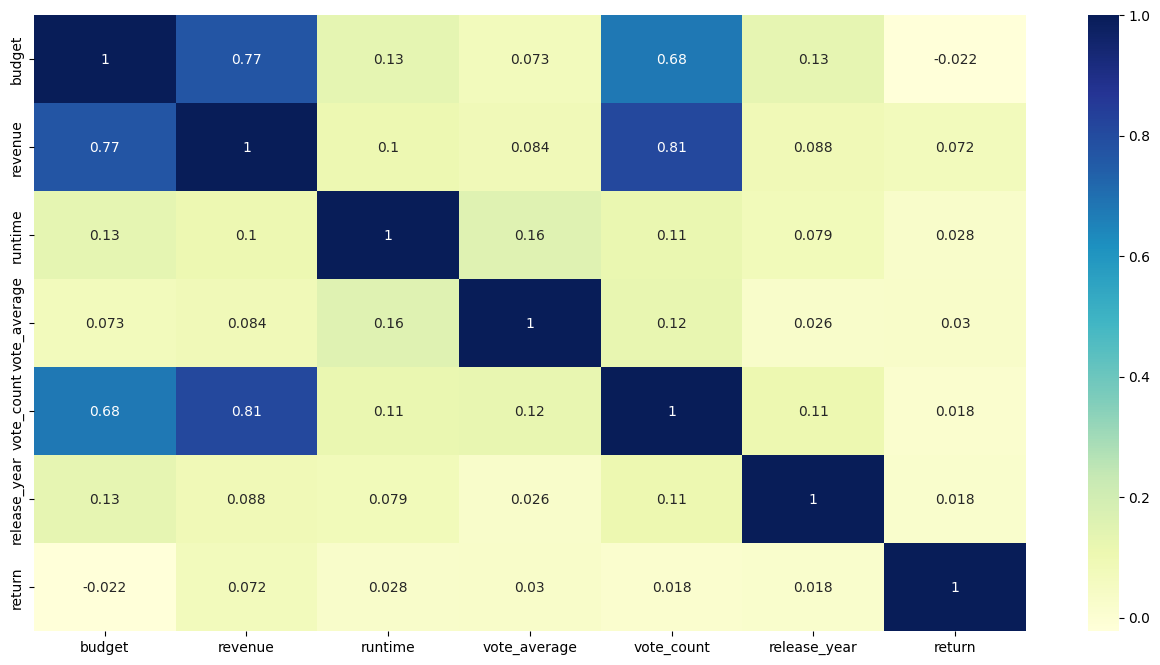

In [2]:

#Correlacion entre variables
#Miramos ahora la correlación entre variables, es buena idea verificar cuáles son las que más correlación tienen, si tienen demasiada correlación, pueden incluir sesgo, y si tienen muy poca, se pueden eliminar sin afectar el rendimiento. Es buena idea revisar cuáles tienen mucha correlación con nuestro objetivo, el precio ´price´, porque serán muy importantes para el modelo.

# Generamos la matriz de correlación

corr = df.corr()
# Ahora, la graficaremos, primero, indicamos el tamaño que tendra el plot.
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [3]:
#En el análisis de variables, observamos que No tenemos informacion de usuario para basarnos en un modelo de recomendación por usuario, por lo que vamos a desestimar esa columna para el analisis y a hacer  un modelo de recomendación por recomendación de contenido, tratando de evaluar la similitud en tre las peliculas. De esta forma, vamos a empelear el modelo de similitud del coseno, y vamos a tomar las columnas que nos puedna dar palabras clave más utilizadas, y que de alguna forma den una medida de similitus para recomendar un pelicula, en base a una pelicula elegida.
#De esta forma, vamos a desechar varias columnas para nuestro modelo, en base a este criterio.
#Nos focalizamos para el modelamiento en variables categóricas
#hay muchos NAN, hay que ver donde estan y quitarlos si es posible
#observamos las columnas overview y titulos engobla a genero, tagline, languages, en cuanto a las palaras más utilizadas
#Para armar nuestro modelo, quitamos la mayoría de variables numericas, y nos centramos en variables Titulo, Overview, género, y belong to collecion, en base a los requerimientos del ejercicio, 
# Tomamos en consideración las películas más votadas (a través de la columna  vote_ount para dar un criterio de corte al dataset y poder probar nuestro modelo de recomendación)

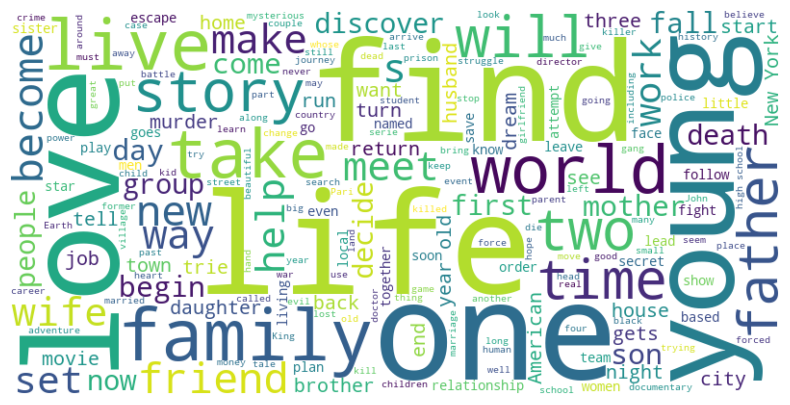

In [4]:

# Crea una lista de stopwords adicionales, luego de observar la nube de palabras
additional_stopwords = ['united', 'states', 'nan', "English","Film", "man", "boy", "girl", "woman", "United Kingdom"]

# Combina las stopwords predeterminadas con las adicionales
stopwords = set(list(STOPWORDS) + additional_stopwords)


# Selecciona las columnas relevantes para la nube de palabras.
selected_columns3 = ['overview', 'title']

# Crea una lista de textos de las columnas seleccionadas.
text_list3 = [df[col].dropna().astype(str).str.strip().tolist() for col in selected_columns3 if col in df]

# Combina los textos en un solo string.
combined_text = ' '.join([text for sublist3 in text_list3 for text in sublist3])
# Crea el objeto de la nube de palabras con las stopwords
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(combined_text)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



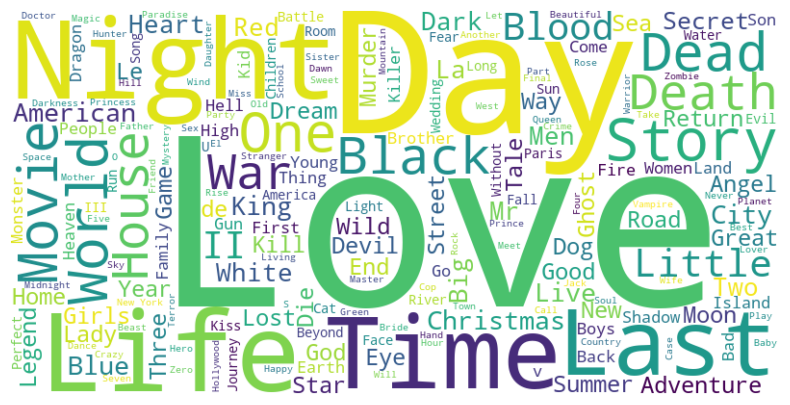

In [5]:

# Crea una lista de stopwords adicionales
additional_stopwords = ['united', 'states', 'nan', "English","Film", "man", "boy", "girl", "woman", "United Kingdom"]

# Combina las stopwords predeterminadas con las adicionales
stopwords = set(list(STOPWORDS) + additional_stopwords)


# Selecciona las columnas relevantes para la nube de palabras.
selected_columns4 = ['title']

# Crea una lista de textos de las columnas seleccionadas.
text_list4 = [df[col].dropna().astype(str).str.strip().tolist() for col in selected_columns4 if col in df]

# Combina los textos en un solo string.
combined_text = ' '.join([text for sublist4 in text_list4 for text in sublist4])
# Crea el objeto de la nube de palabras con las stopwords
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(combined_text)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [6]:
df.drop_duplicates()

,budget,id_pelicula,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,genres_ok,spoken_languages_ok,production_countries,belong_to_collection,production_companies_ok,release_year,return
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,NaN,Toy Story,7.7,5415,"Animation,Comedy,Family",English,United States of America,Toy Story Collection,Pixar Animation Studios,1995,12.45
1,65000000.0,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413,"Adventure,Fantasy,Family","English,Français",United States of America,NaN,"TriStar Pictures,Teitler Film,Interscope Commu...",1995,4.04
2,1.0,15602,en,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92,"Romance,Comedy",English,United States of America,Grumpy Old Men Collection,"Warner Bros.,Lancaster Gate",1995,0.00
3,16000000.0,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34,"Comedy,Drama,Romance",English,United States of America,NaN,Twentieth Century Fox Film Corporation,1995,5.09
4,1.0,11862,en,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173,Comedy,English,United States of America,Father of the Bride Collection,"Sandollar Productions,Touchstone Pictures",1995,76578911.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45374,1.0,30840,en,"Yet another version of the classic epic, with ...",5.683753,1991-05-13,0.0,104.0,Released,NaN,Robin Hood,5.7,26,"Drama,Action,Romance",English,"Canada,Germany,United Kingdom,United States of...",NaN,"Westdeutscher Rundfunk (WDR),Working Title Fil...",1991,0.00
45375,1.0,111109,tl,An artist struggles to finish his work while a...,0.178241,2011-11-17,0.0,360.0,Released,NaN,Century of Birthing,9.0,3,Drama,NaN,Philippines,NaN,Sine Olivia,2011,0.00
45376,1.0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,90.0,Released,A deadly game of wits.,Betrayal,3.8,6,"Action,Drama,Thriller",English,United States of America,NaN,American World Pictures,2003,0.00
45377,1.0,227506,en,"In a small town live two brothers, one a minis...",0.003503,1917-10-21,0.0,87.0,Released,NaN,Satan Triumphant,0.0,0,NaN,NaN,Russia,NaN,Yermoliev,1917,0.00


In [7]:
df.tail()

,budget,id_pelicula,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,genres_ok,spoken_languages_ok,production_countries,belong_to_collection,production_companies_ok,release_year,return
45374,1.0,30840,en,"Yet another version of the classic epic, with ...",5.683753,1991-05-13,0.0,104.0,Released,NaN,Robin Hood,5.7,26,"Drama,Action,Romance",English,"Canada,Germany,United Kingdom,United States of...",NaN,"Westdeutscher Rundfunk (WDR),Working Title Fil...",1991,0.0
45375,1.0,111109,tl,An artist struggles to finish his work while a...,0.178241,2011-11-17,0.0,360.0,Released,NaN,Century of Birthing,9.0,3,Drama,NaN,Philippines,NaN,Sine Olivia,2011,0.0
45376,1.0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,90.0,Released,A deadly game of wits.,Betrayal,3.8,6,"Action,Drama,Thriller",English,United States of America,NaN,American World Pictures,2003,0.0
45377,1.0,227506,en,"In a small town live two brothers, one a minis...",0.003503,1917-10-21,0.0,87.0,Released,NaN,Satan Triumphant,0.0,0,NaN,NaN,Russia,NaN,Yermoliev,1917,0.0
45378,1.0,461257,en,50 years after decriminalisation of homosexual...,0.163015,2017-06-09,0.0,75.0,Released,NaN,Queerama,0.0,0,NaN,English,United Kingdom,NaN,NaN,2017,0.0


In [8]:
# Eliminar registros duplicados y mantener la primera aparición
df.drop_duplicates("title")

# Imprimir el DataFrame con registros duplicados eliminados
df["title"].head()

0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
Name: title, dtype: object

In [9]:

# Paso 2: Procesamiento de texto utilizando la columna 'overview'
# Lidiar con valores nulos en la columna 'overview' (si es necesario)
df['title'].fillna('', inplace=True)


In [10]:
df["genres_ok"].fillna('', inplace=True)
df["vote_count"].fillna('', inplace=True)
df["belong_to_collection"].fillna('', inplace=True)
df["overview"].fillna(" ", inplace= True)

In [11]:
df["title"].head()

0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
Name: title, dtype: object

In [12]:
df["status"]
valores_unicos = df["status"].unique()
print("Valores únicos en la columna 'status':", valores_unicos)

Valores únicos en la columna 'status': ['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [13]:
# Filtrar las filas con el valor "released" en la columna "status"
filas_released = df[df["status"] == "Released"]

In [14]:

# Crear un nuevo DataFrame con las filas filtradas
nuevo_df = pd.DataFrame(filas_released)

In [15]:
nuevo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44936 entries, 0 to 45378
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   budget                   44936 non-null  float64
 1   id_pelicula              44936 non-null  object 
 2   original_language        44926 non-null  object 
 3   overview                 44936 non-null  object 
 4   popularity               44936 non-null  object 
 5   release_date             44936 non-null  object 
 6   revenue                  44936 non-null  float64
 7   runtime                  44696 non-null  float64
 8   status                   44936 non-null  object 
 9   tagline                  20287 non-null  object 
 10  title                    44936 non-null  object 
 11  vote_average             44936 non-null  float64
 12  vote_count               44936 non-null  Int32  
 13  genres_ok                44936 non-null  object 
 14  spoken_languages_ok   

In [16]:
nuevo_df.shape #se redujero un poco más de 1000 registros, aun falta optimizar por falta de memoria

(44936, 20)

In [17]:
# Aplicar criterio de ordenar el DataFrame por la columna "vote_count" de manera descendente para tomar las primeras 5000 filas más votadas
votadas_df = nuevo_df.sort_values(by="vote_count", ascending=False).head(5000)

In [18]:
# Reemplazar valores nulos en columnas seleccionadas con un valor predeterminado (por ejemplo, "")
columns_to_fill = ['overview', 'tagline', 'genres_ok', 'spoken_languages_ok', 'production_countries', 'production_companies_ok', 'belong_to_collection']
votadas_df[columns_to_fill] = votadas_df[columns_to_fill].fillna("")

In [19]:

# Exportar el DataFrame reducido de las mas votadas a un archivo CSV
votadas_df.to_csv('votadas_df.csv', index=False)


In [20]:
votadas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 15473 to 2077
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   budget                   5000 non-null   float64
 1   id_pelicula              5000 non-null   object 
 2   original_language        5000 non-null   object 
 3   overview                 5000 non-null   object 
 4   popularity               5000 non-null   object 
 5   release_date             5000 non-null   object 
 6   revenue                  5000 non-null   float64
 7   runtime                  5000 non-null   float64
 8   status                   5000 non-null   object 
 9   tagline                  5000 non-null   object 
 10  title                    5000 non-null   object 
 11  vote_average             5000 non-null   float64
 12  vote_count               5000 non-null   Int32  
 13  genres_ok                5000 non-null   object 
 14  spoken_languages_ok 

In [21]:
votadas_df[votadas_df["title"] == "Toy Story"]

,budget,id_pelicula,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,genres_ok,spoken_languages_ok,production_countries,belong_to_collection,production_companies_ok,release_year,return
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,,Toy Story,7.7,5415,"Animation,Comedy,Family",English,United States of America,Toy Story Collection,Pixar Animation Studios,1995,12.45


In [22]:

# Buscar la película "Toy Story" en el DataFrame votadas_df
toy_story = votadas_df.loc[votadas_df["title"] == "Toy Story"]
print(toy_story)

       budget id_pelicula original_language  \
0  30000000.0         862                en   

                                            overview popularity release_date  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   1995-10-30   

       revenue  runtime    status tagline      title  vote_average  \
0  373554033.0     81.0  Released          Toy Story           7.7   

   vote_count                genres_ok spoken_languages_ok  \
0        5415  Animation,Comedy,Family             English   

       production_countries  belong_to_collection  production_companies_ok  \
0  United States of America  Toy Story Collection  Pixar Animation Studios   

   release_year  return  
0          1995   12.45  


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Aplicar técnicas de procesamiento de texto a la columna 'overview'
vectorizer = TfidfVectorizer(stop_words='english')

#actualizamos la lista de palabras con las stopwords que surgieron tras los ejercicios de las nubes de palabras 
vectorizer.stop_words_ = vectorizer.get_stop_words().union(stopwords)

overview_vectors = vectorizer.fit_transform(votadas_df['overview'])

# Obtener la matriz de características procesadas
processed_features = overview_vectors.toarray()

In [24]:
vector_overview_preprocessed = processed_features  

In [25]:
# Aplicar técnicas de procesamiento de texto a la columna 'title'
vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.stop_words_ = vectorizer.get_stop_words().union(stopwords)

title_vectors = vectorizer.fit_transform(votadas_df['title'])

# Obtener la matriz de características procesadas
processed_features1 = title_vectors.toarray()
vector_titles_titles_preprocessed = processed_features1 


In [26]:
# Codificación one-hot del belong to collection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
encoder = OneHotEncoder()
btc_encoded = encoder.fit_transform(votadas_df["belong_to_collection"].values.reshape(-1, 1)).toarray()

In [27]:
# Codificación one-hot del género
#encoder = OneHotEncoder()
genre_encoded = encoder.fit_transform(votadas_df["genres_ok"].values.reshape(-1, 1)).toarray()


print(vector_overview_preprocessed.shape)
print(vector_titles_titles_preprocessed.shape)
print(votadas_df['vote_count'].values.reshape(-1, 1).shape)
print(genre_encoded.shape)
print(btc_encoded.shape)


# Combina los vectores de títulos preprocesados c columnas 'vote_count' y género
features_combined = np.concatenate((vector_overview_preprocessed, vector_titles_titles_preprocessed, votadas_df['vote_count'].values.reshape(-1, 1), genre_encoded, btc_encoded), axis=1)

# Normalización de características si es necesario
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_combined)

# Calcula la matriz de similitud del coseno entre las películas
similarity_matrix = cosine_similarity(features_scaled)

(5000, 20718)
(5000, 4408)
(5000, 1)
(5000, 1257)
(5000, 649)


In [28]:
votadas_df["genres_ok"].head(100)

15473    Action,Thriller,Science Fiction,Mystery,Adventure
12476                          Drama,Action,Crime,Thriller
14545             Action,Adventure,Fantasy,Science Fiction
17807                     Science Fiction,Action,Adventure
26535                              Action,Adventure,Comedy
                               ...                        
1917                                     Drama,History,War
41423                     Action,Adventure,Science Fiction
11657                                 Action,Adventure,War
6720                                          Action,Crime
17115                             Adventure,Action,Fantasy
Name: genres_ok, Length: 100, dtype: object

In [29]:


movie_title = "Toy Story"

# Encuentra el índice de la película basado en el título
index = votadas_df[votadas_df["title"] == movie_title].index[0]

# Filtrar las películas similares por género apropiado para niños (Animación o Familia)
filtered_similar_movies = [movie_index for movie_index in range(len(similarity_matrix[index]))
                           if any(keyword in genre for keyword in ['Animation', 'Family'] for genre in votadas_df['genres_ok'].iloc[movie_index].split(','))]

# Calcular la similitud solo para las películas filtradas
filtered_similarity_scores = similarity_matrix[index][filtered_similar_movies]

# Obtener las películas más recomendadas (excluyendo la película de referencia)
similar_movies = np.argsort(filtered_similarity_scores)[::-1][1:6]

# Imprime los títulos de las películas similares apropiadas para niños
for movie_index in similar_movies:
    print(votadas_df['title'].iloc[filtered_similar_movies[movie_index]])


Cowboy Bebop: The Movie
Anastasia
Cars 2
Race to Witch Mountain
Cloudy with a Chance of Meatballs
